<a href="https://colab.research.google.com/github/chierighini/notes/blob/main/applied_data_science_python5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applied Data Science with Python, Part 5

## Model Evaluation
To evaluate how well our model will perform in the real world we can split the data into training data and testing data. The model will be trained using a larger part of the data and then tested with the rest to see it's performance. After testing our model, all of the data should be used to train it, and make it more accurate. `sklearn.model_selection` has a function to split the data called `train_test_split`.

### Generalization Performance
Generalization error is a measure of how well our model can predict new data. The error obtained in testing is an approximation of this error.

### Cross Validation
Cross Validation is the most common out-of-sample evaluation metric. It splits the data into equal parts and uses combinations of these parts for both training and testing, and then calculates an average error. `sklearn.model_selection` has a function called `cross_val_score()`.

Another useful function is the `cross_val_predict()` from the same module. It returns the prediction for each element from when it was in the testing set.

## Overfitting, Underfitting and Model Selection
* Underfitting: the model is too simple to fit the data.
* Overfitting: the model is too flexible, and fits the noise better than the actual values.

We must always be careful when fitting the data to be able to predict more accurately new values. Minimizing the error is the best way to do this, since a too simple model may not predict new values well, and a too comples model may give preference to noise, rather than the values themselves.

## Ridge Regression
Ridge Regression is mainly used to prevent underfitting. We use an alpha value to "measure" the coeficients of each variable to determine if it is a good fit or not.`sklearn.linear_model` has a constructor for that called `Ridge`. The goal is to select a value of alpha that maximizes the $R^2$ or minimizes the MSE.

## Grid Search
Is a way to iterate over free parameters, or hyperparameters, such as the alpha value disscussed previously. We iterate over different values of the hyperparameters and train our model. We then select the one that minimizes the error.

##Lab Exercises

### Setup

In [ ]:
import pandas as pd
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/module_5_auto.csv

In [ ]:
df = pd.read_csv("/content/module_5_auto.csv")

In [ ]:
df=df._get_numeric_data()
df.head()

,Unnamed: 0,Unnamed: 0.1,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,diesel,gas
0,0,0,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,11.190476,0,1
1,1,1,3,122,88.6,0.811148,0.890278,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,11.190476,0,1
2,2,2,1,122,94.5,0.822681,0.909722,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,12.368421,0,1
3,3,3,2,164,99.8,0.848630,0.919444,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,9.791667,0,1
4,4,4,2,164,99.4,0.848630,0.922222,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,13.055556,0,1


#### Functions for plotting

In [ ]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax3 = sns.displot([RedFunction,BlueFunction],kind='kde')


    plt.title(Title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [ ]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

### Training and Testing
The first step is to split our data.

In [ ]:
y_data = df['price']

In [ ]:
x_data=df.drop('price',axis=1)

Here we separate the price column in a different frame and remove it from our variables.

Now to split the rest of the data:

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.10, random_state=1)


print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 21
number of training samples: 180


####Exercise 1
Write the `train_test_split()`function such as the test size is 40% of the originial data and that `random_state=0`

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data, y_data,test_size=0.4,random_state=0)
print("number of test samples :", x_test1.shape[0])
print("number of training samples:",x_train1.shape[0])

number of test samples : 81
number of training samples: 120


Creating a linear regression object we can see that the $R^2$ for the training data is much higher than the one in the test data.

In [ ]:
lre=LinearRegression()

In [ ]:
lre.fit(x_train[['horsepower']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lre.score(x_test[['horsepower']], y_test)

0.36358755750788263

In [ ]:
lre.score(x_train[['horsepower']], y_train)

0.6619724197515104

#### Exercise 2
Find the $R^2$ on the test data using 90% of the data for training data.

In [ ]:
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_data,y_data,test_size=0.1,random_state=0)

In [ ]:
lre.fit(x_train2[['horsepower']], y_train2)
lre.score(x_test2[['horsepower']], y_test2)

0.7340722810055448

As we do not have that much testing data, we may want to do a cross validation.

### Cross-validation score

In cross validation we use the folds to determine the mean $R^2$, standard deviation, and even the MSE.

Here we have 4 folds, in the `cv` variable.

In [ ]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=4)

In [ ]:
Rcross

array([0.7746232 , 0.51716687, 0.74785353, 0.04839605])

In [ ]:
Rcross.mean()

0.522009915042119

In [ ]:
Rcross.std()

0.291183944475603

In [ ]:
-1 * cross_val_score(lre,x_data[['horsepower']], y_data,cv=4,scoring='neg_mean_squared_error')

array([20254142.84026702, 43745493.2650517 , 12539630.34014931,
       17561927.72247591])

#### Exercise 3
Calculate the aerage $R^2$ using two folds. Use horsepower as a feature.

In [ ]:
Rcross = cross_val_score(lre, x_data[['horsepower']], y_data, cv=2)

In [ ]:
Rcross.mean()

0.5166761697127429

We can also use `cross_val_predict()` to predict an output.

In [ ]:
yhat = cross_val_predict(lre,x_data[['horsepower']], y_data,cv=4)
yhat[0:5]

array([14141.63807508, 14141.63807508, 20814.29423473, 12745.03562306,
       14762.35027598])

### Overfitting, Underfitting and Model Selection

Here we create a linear regression object and put multiple variabels inside it. Then we make predictions based on our training data and testing data, and plot them against the data used to predict them.

In [ ]:
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
yhat_train = lr.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([ 7426.6731551 , 28323.75090803, 14213.38819709,  4052.34146983,
       34500.19124244])

In [ ]:
yhat_test = lr.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.35089149,  5884.11059106, 11208.6928275 ,  6641.07786278,
       15565.79920282])

<Figure size 864x720 with 0 Axes>

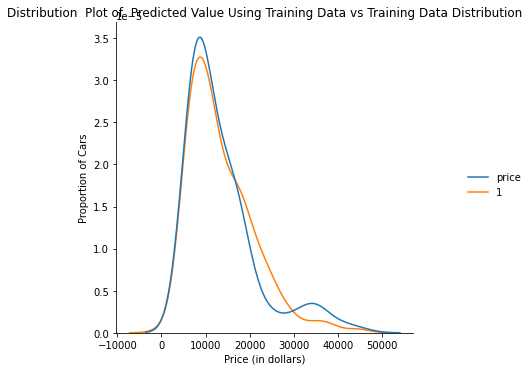

In [ ]:
Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", Title)

<Figure size 864x720 with 0 Axes>

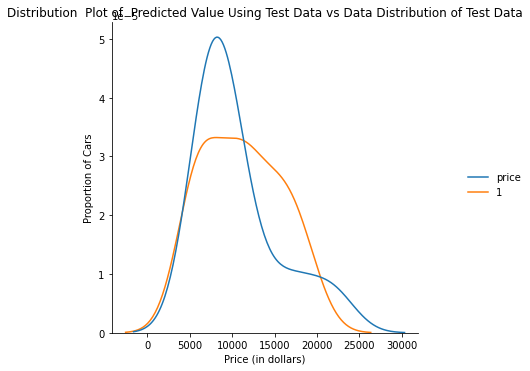

In [ ]:
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,yhat_test,"Actual Values (Test)","Predicted Values (Test)",Title)

The training data does fairly well in predicting the actual values, however, the test data does not.

#### Overfitting
Here we make a 5th order polynomial regression.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

In [ ]:
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5, include_bias=True, interaction_only=False,
                   order='C')

In [ ]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6728.65561887,  7307.98782321, 12213.78770965, 18893.24804015,
       19995.95195136])

In [ ]:
print("Predicted values:", yhat[0:4])
print("True values:", y_test[0:4].values)

Predicted values: [ 6728.65561887  7307.98782321 12213.78770965 18893.24804015]
True values: [ 6295. 10698. 13860. 13499.]


As we can see, after a while the price dops for a higher horsepower, which is not correct.

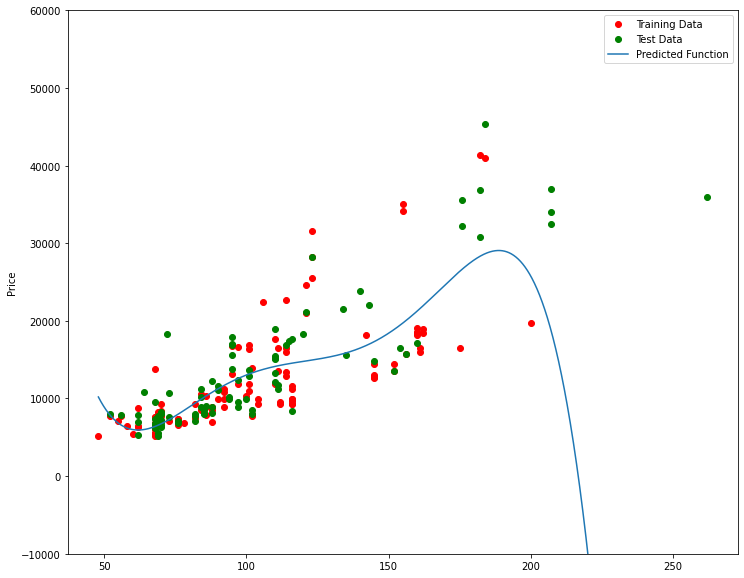

In [ ]:
PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly,pr)

In [ ]:
poly.score(x_train_pr, y_train)

0.556771690212023

In [ ]:
poly.score(x_test_pr, y_test)

-29.871340302044153

And here, for each order of polynomial regression, we get a different value of $R^2$, and note that after the 3rd order, the values starts to decrease.

Text(3, 0.75, 'Maximum R^2 ')

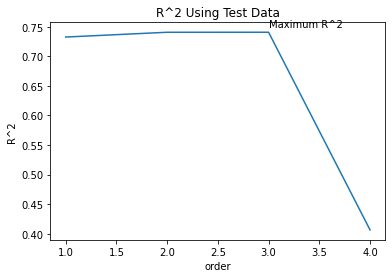

In [ ]:
Rsqu_test = []

order = [1, 2, 3, 4]
for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])    
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')    

In [ ]:
def f(order, test_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_data, random_state=0)
    pr = PolynomialFeatures(degree=order)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    poly = LinearRegression()
    poly.fit(x_train_pr,y_train)
    PollyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train,y_test, poly, pr)

In [ ]:
interact(f, order=(0, 6, 1), test_data=(0.05, 0.95, 0.05))

interactive(children=(IntSlider(value=3, description='order', max=6), FloatSlider(value=0.45, description='tes…

<function __main__.f>

##### Exercise 4a
Create a `PolynomialFeature()` object `pr1` with a degree of 2.

In [ ]:
pr1 = PolynomialFeatures(degree=2)

#####Exercise 4b
Transform the training and testing samples for the features 'horsepower', 'curb-weight', 'engine-size' and 'highway-mpg'.

In [ ]:
x_train_pr1=pr1.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

x_test_pr1=pr1.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])

##### Exercise 4c
How many dimensions does the new feature have?

In [ ]:
x_train_pr1.shape

(110, 15)

##### Exercise 4d
Create a linear regression model "poly1" and train the object using the method "fit" using the polynomial features?

In [ ]:
poly1 = LinearRegression()

In [ ]:
poly1.fit(x_train_pr1,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

##### Exercise 4e
Use the method  "predict" to predict an output on the polynomial features, then use the function "DistributionPlot"  to display the distribution of the predicted output vs the test data.

<Figure size 864x720 with 0 Axes>

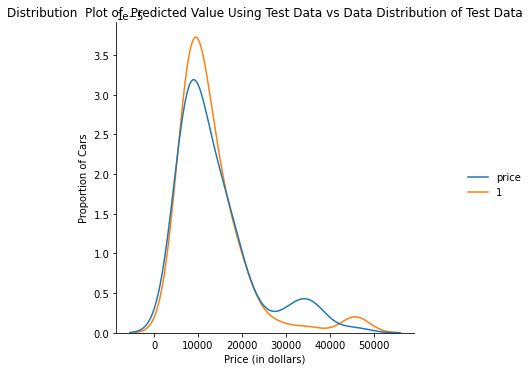

In [ ]:
yhat_test1=poly1.predict(x_test_pr1)
Title='Distribution  Plot of  Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test, yhat_test1, "Actual Values (Test)", "Predicted Values (Test)", Title)

##### Exercise 4f
Using the distribution plot above, explain in words about the two regions were the predicted prices are less accurate than the actual prices

The predicted prices are higher than the actual prices in the 10000 dollars range and the 30000 dollar to 40000 dollar range predictions are smaller. This indicates our model is not accurate in these ranges.

### Ridge Regression
Here we will see how the alpha value changes our model.

In [ ]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])
x_test_pr=pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']])

In [ ]:
RigeModel=Ridge(alpha=0.1)

In [ ]:
RigeModel.fit(x_train_pr, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.02972e-16): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
yhat = RigeModel.predict(x_test_pr)

In [ ]:
print('predicted:', yhat[0:4])
print('test set :', y_test[0:4].values)

predicted: [ 6567.83081933  9597.97151399 20836.22326843 19347.69543463]
test set : [ 6295. 10698. 13860. 13499.]


Here we take the alpha value that minimizes the error.

In [ ]:
Rsqu_test = []
Rsqu_train = []
dummy1 = []
Alpha = 10 * np.array(range(0,1000))
for alpha in Alpha:
    RigeModel = Ridge(alpha=alpha) 
    RigeModel.fit(x_train_pr, y_train)
    Rsqu_test.append(RigeModel.score(x_test_pr, y_test))
    Rsqu_train.append(RigeModel.score(x_train_pr, y_train))

And now we plot the values of $R^2$ for each alpha.

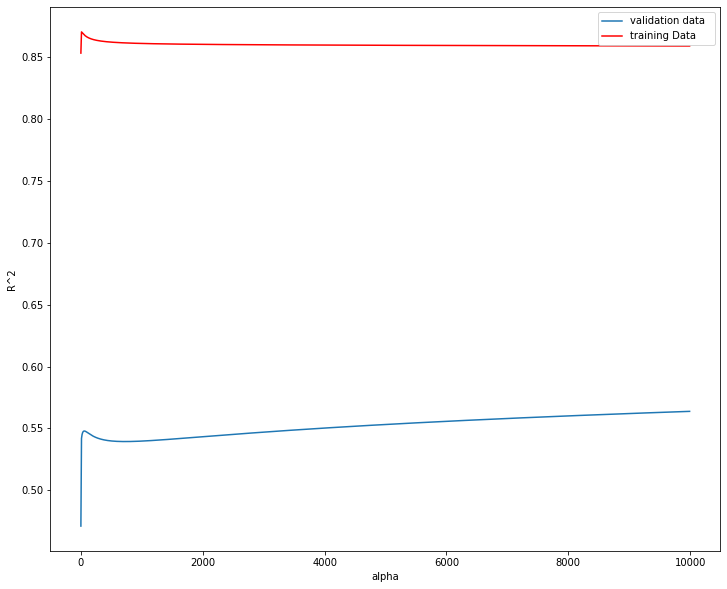

In [ ]:
width = 12
height = 10
plt.figure(figsize=(width, height))

plt.plot(Alpha,Rsqu_test, label='validation data  ')
plt.plot(Alpha,Rsqu_train, 'r', label='training Data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

####Exercise 5
Perform Ridge regression and calculate the R^2 using the polynomial features, use the training data to train the model and test data to test the model. The parameter alpha should be set to  10.

In [ ]:
RigeModel = Ridge(alpha=10)
RigeModel.fit(x_train_pr,y_train)
RigeModel.score(x_test_pr,y_test)

0.5418576440206702

### Grid Search

In the following code, we set a list of parameters, create a Ridge regions oject, Create a ridge grid search, fit the model in it, and print out the best score.

In [ ]:
parameters1= [{'alpha': [0.001,0.1,1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [ ]:
RR=Ridge()
RR

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
Grid1 = GridSearchCV(RR, parameters1,cv=4)

In [ ]:
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
BestRR=Grid1.best_estimator_
BestRR

Ridge(alpha=10000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411649831036152

####Exercise 6
Perform a grid search for the alpha parameter and the normalization parameter, then find the best values of the parameters

In [ ]:
parameters2= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000],'normalize':[True,False]} ]
Grid2 = GridSearchCV(Ridge(), parameters2,cv=4)
Grid2.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']],y_data)
Grid2.best_estimator_

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

#Final Considerations

This notebook was based off of the "applied data science with python" course from cognitive class (https://cognitiveclass.ai/) and is a compilation of my notes and important topics from it.

This course is one of the best things I came across as a student and I'm very thankful for IBM to have made this available for free.

A few parts were taken out of their lab notebook, that was written by the following people:

<a href="https://www.linkedin.com/in/joseph-s-50398b136/" target="_blank">Joseph Santarcangelo</a>

<a href="https://www.linkedin.com/in/mahdi-noorian-58219234/" target="_blank">Mahdi Noorian PhD</a>

Bahare Talayian

Eric Xiao

Steven Dong

Parizad

Hima Vasudevan

<a href="https://www.linkedin.com/in/fiorellawever/" target="_blank">Fiorella Wenver</a>

<a href=" https://www.linkedin.com/in/yi-leng-yao-84451275/ " target="_blank" >Yi Yao</a>.

Kudos to IBM and it's authors for keeping this knowledge free.